In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_8(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_8, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
    

        x = torch.relu(self.layer3(x))
        

        x = torch.relu(self.layer4(x))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_8(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:16:32,645] A new study created in memory with name: no-name-ab6e7e08-d893-4986-93d6-1ef4cd73a403
/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:17:07,120] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.008648061655277218, 'weight_decay': 7.633391748879927e-05}. Best is trial 0 with value: 0

Early stopping at epoch 11
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:18:31,369] Trial 1 finished with value: 0.18000752243879722 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.00017608582611524807, 'weight_decay': 7.753930420770487e-05}. Best is trial 1 with value: 0.18000752243879722.


Early stopping at epoch 26
Final MCC: 0.1800


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:19:47,974] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.1, 'learning_rate': 0.003245274455036647, 'weight_decay': 0.0001062125349992627}. Best is trial 1 with value: 0.18000752243879722.


Early stopping at epoch 22
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:20:35,580] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0007981625652423851, 'weight_decay': 0.0027658583273447663}. Best is trial 1 with value: 0.18000752243879722.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:21:56,526] Trial 4 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.25, 'learning_rate': 0.00108976324142219, 'weight_decay': 0.003794159467219257}. Best is trial 1 with value: 0.18000752243879722.


Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:23:29,738] Trial 5 finished with value: 0.25682551112411406 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.00032734487969582175, 'weight_decay': 2.4168423704525976e-05}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 27
Final MCC: 0.2568


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:25:00,346] Trial 6 finished with value: 0.2519965173697301 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 0.00021717291627062184, 'weight_decay': 0.0012836572273118216}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 26
Final MCC: 0.2520


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:28:40,080] Trial 7 finished with value: 0.1819942682049714 and parameters: {'dropout1': 0.45, 'dropout2': 0.5, 'learning_rate': 0.00014881592417235703, 'weight_decay': 0.0004997114590735558}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 64
Final MCC: 0.1820


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:29:43,090] Trial 8 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.0063777956980766975, 'weight_decay': 1.9478867847746776e-05}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 17
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:29:46,671] Trial 9 pruned. 
[I 2024-12-04 16:29:50,295] Trial 10 pruned. 
[I 2024-12-04 16:29:53,996] Trial 11 pruned. 
[I 2024-12-04 16:31:16,699] Trial 12 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 0.00028267937316943034, 'weight_decay': 0.00777502525515881}. Best i

Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:33:43,869] Trial 13 finished with value: 0.17173551629643674 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00010092835862512133, 'weight_decay': 0.0009987562178337048}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 41
Final MCC: 0.1717


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:33:47,502] Trial 14 pruned. 
[I 2024-12-04 16:33:51,037] Trial 15 pruned. 
[I 2024-12-04 16:33:54,654] Trial 16 pruned. 
[I 2024-12-04 16:33:58,222] Trial 17 pruned. 
[I 2024-12-04 16:37:08,642] Trial 18 finished with value: 0.0871165065546462 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.0001

Early stopping at epoch 52
Final MCC: 0.0871


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:37:12,424] Trial 19 pruned. 
[I 2024-12-04 16:37:16,224] Trial 20 pruned. 
[I 2024-12-04 16:41:00,344] Trial 21 finished with value: 0.16521472925295919 and parameters: {'dropout1': 0.45, 'dropout2': 0.5, 'learning_rate': 0.00016967353687083174, 'weight_decay': 0.0007375291633943614}. Best is trial 5 with value: 0.25682551112411406.

Early stopping at epoch 60
Final MCC: 0.1652


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:42:52,560] Trial 22 finished with value: 0.17261205881162434 and parameters: {'dropout1': 0.4, 'dropout2': 0.45, 'learning_rate': 0.00013729590540321608, 'weight_decay': 0.0004598698492776341}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 30
Final MCC: 0.1726


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:42:56,196] Trial 23 pruned. 
[I 2024-12-04 16:42:59,848] Trial 24 pruned. 
[I 2024-12-04 16:43:03,563] Trial 25 pruned. 
[I 2024-12-04 16:43:07,182] Trial 26 pruned. 
[I 2024-12-04 16:43:10,750] Trial 27 pruned. 
[I 2024-12-04 16:43:14,409] Trial 28 pruned. 
[I 2024-12-04 16:43:18,060] Trial 29 pruned. 
[I 2024-12-04 16:45:53,462] T

Early stopping at epoch 42
Final MCC: 0.1642


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:45:57,158] Trial 31 pruned. 
[I 2024-12-04 16:46:00,764] Trial 32 pruned. 
[I 2024-12-04 16:46:04,438] Trial 33 pruned. 
[I 2024-12-04 16:46:08,188] Trial 34 pruned. 
[I 2024-12-04 16:46:11,821] Trial 35 pruned. 
[I 2024-12-04 16:46:15,484] Trial 36 pruned. 
[I 2024-12-04 16:46:19,169] Trial 37 pruned. 
[I 2024-12-04 16:46:22,967] T

Early stopping at epoch 39
Final MCC: 0.1834


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:48:58,736] Trial 42 pruned. 
[I 2024-12-04 16:49:02,466] Trial 43 pruned. 
[I 2024-12-04 16:54:42,096] Trial 44 finished with value: 0.18182193636434194 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.00010940120185217773, 'weight_decay': 0.00022632622518718344}. Best is trial 5 with value: 0.25682551112411406.

Early stopping at epoch 90
Final MCC: 0.1818


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:36,429] Trial 45 finished with value: 0.1535963434938927 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0001049037614099603, 'weight_decay': 0.0007500784021028682}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 78
Final MCC: 0.1536


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:40,039] Trial 46 pruned. 
[I 2024-12-04 16:59:43,641] Trial 47 pruned. 
[I 2024-12-04 17:01:50,281] Trial 48 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.0001606483932224363, 'weight_decay': 0.0034212588810772827}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 33
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:01:54,163] Trial 49 pruned. 
[I 2024-12-04 17:04:14,413] Trial 50 finished with value: 0.03711575928451468 and parameters: {'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00011948731374729846, 'weight_decay': 0.0010910169095412225}. Best is trial 5 with value: 0.25682551112411406.


Early stopping at epoch 36
Final MCC: 0.0371


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:04:18,261] Trial 51 pruned. 
[I 2024-12-04 17:05:30,327] Trial 52 finished with value: 0.3489249062843808 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.004663292460116884, 'weight_decay': 0.0003894511013276207}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 18
Final MCC: 0.3489


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:05:34,139] Trial 53 pruned. 
[I 2024-12-04 17:05:37,939] Trial 54 pruned. 
[I 2024-12-04 17:05:41,760] Trial 55 pruned. 
[I 2024-12-04 17:05:45,597] Trial 56 pruned. 
[I 2024-12-04 17:05:49,367] Trial 57 pruned. 
[I 2024-12-04 17:05:53,152] Trial 58 pruned. 
[I 2024-12-04 17:05:57,007] Trial 59 pruned. 
[I 2024-12-04 17:06:00,913] T

Early stopping at epoch 33
Final MCC: 0.2592


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:08:13,774] Trial 62 pruned. 
[I 2024-12-04 17:08:17,589] Trial 63 pruned. 
[I 2024-12-04 17:09:58,898] Trial 64 finished with value: 0.17173551629643674 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.00020227507169662818, 'weight_decay': 0.00014559441182600025}. Best is trial 52 with value: 0.3489249062843808

Early stopping at epoch 28
Final MCC: 0.1717


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:10:02,337] Trial 65 pruned. 
[I 2024-12-04 17:10:05,710] Trial 66 pruned. 
[I 2024-12-04 17:10:09,123] Trial 67 pruned. 
[I 2024-12-04 17:10:12,542] Trial 68 pruned. 
[I 2024-12-04 17:13:54,658] Trial 69 finished with value: 0.21317921603960482 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.000121987100004963

Early stopping at epoch 64
Final MCC: 0.2132


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:13:58,089] Trial 70 pruned. 
[I 2024-12-04 17:16:11,592] Trial 71 finished with value: 0.21039247703903016 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.0001263935493460063, 'weight_decay': 0.0005372706594485377}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 42
Final MCC: 0.2104


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:16:14,685] Trial 72 pruned. 
[I 2024-12-04 17:16:17,759] Trial 73 pruned. 
[I 2024-12-04 17:16:20,877] Trial 74 pruned. 
[I 2024-12-04 17:16:23,959] Trial 75 pruned. 
[I 2024-12-04 17:16:27,025] Trial 76 pruned. 
[I 2024-12-04 17:16:30,122] Trial 77 pruned. 
[I 2024-12-04 17:16:33,228] Trial 78 pruned. 
[I 2024-12-04 17:16:36,294] T

Early stopping at epoch 45
Final MCC: 0.1368


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:20:50,577] Trial 82 finished with value: 0.24065912324457253 and parameters: {'dropout1': 0.45, 'dropout2': 0.5, 'learning_rate': 0.0001003403290042788, 'weight_decay': 0.00021342625436860253}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 35
Final MCC: 0.2407


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:22:59,471] Trial 83 finished with value: 0.1535963434938927 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00010046587410593148, 'weight_decay': 0.0002858565801357828}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 41
Final MCC: 0.1536


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:23:02,588] Trial 84 pruned. 
[I 2024-12-04 17:24:44,057] Trial 85 finished with value: 0.11604949229779804 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.00015993306807657402, 'weight_decay': 0.0006963334419263542}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 32
Final MCC: 0.1160


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:27:36,645] Trial 86 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00014375425068107242, 'weight_decay': 0.0011469136866011467}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 55
Final MCC: 0.0000


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:29:42,871] Trial 87 finished with value: 0.1961584568159891 and parameters: {'dropout1': 0.4, 'dropout2': 0.25, 'learning_rate': 0.00011825742681536998, 'weight_decay': 0.000151387281407923}. Best is trial 52 with value: 0.3489249062843808.


Early stopping at epoch 39
Final MCC: 0.1962


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:29:46,065] Trial 88 pruned. 
[I 2024-12-04 17:29:49,225] Trial 89 pruned. 
[I 2024-12-04 17:29:52,438] Trial 90 pruned. 
[I 2024-12-04 17:29:55,600] Trial 91 pruned. 
[I 2024-12-04 17:29:58,781] Trial 92 pruned. 
[I 2024-12-04 17:30:01,953] Trial 93 pruned. 
[I 2024-12-04 17:32:41,099] Trial 94 finished with value: 0.232368849519973

Early stopping at epoch 50
Final MCC: 0.2324


/tmp/ipykernel_282439/2103871243.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282439/2103871243.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:32:44,225] Trial 95 pruned. 
[I 2024-12-04 17:32:47,347] Trial 96 pruned. 
[I 2024-12-04 17:32:50,492] Trial 97 pruned. 
[I 2024-12-04 17:32:53,618] Trial 98 pruned. 
[I 2024-12-04 17:32:56,746] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.004663292460116884, 'weight_decay': 0.0003894511013276207}
Best Validation F1:  0.3489249062843808


Epoch [1/100], Loss: 0.5958
Epoch [1/100], Train Loss: 0.5958, Val Loss: 0.5708
Epoch [2/100], Loss: 0.5817
Epoch [2/100], Train Loss: 0.5817, Val Loss: 0.5694
Epoch [3/100], Loss: 0.5837
Epoch [3/100], Train Loss: 0.5837, Val Loss: 0.5647
Epoch [4/100], Loss: 0.5880
Epoch [4/100], Train Loss: 0.5880, Val Loss: 0.5680
Epoch [5/100], Loss: 0.5762
Epoch [5/100], Train Loss: 0.5762, Val Loss: 0.5718
Epoch [6/100], Loss: 0.5794
Epoch [6/100], Train Loss: 0.5794, Val Loss: 0.5610
Epoch [7/100], Loss: 0.5761
Epoch [7/100], Train Loss: 0.5761, Val Loss: 0.5698
Epoch [8/100], Loss: 0.5716
Epoch [8/100], Train Loss: 0.5716, Val Loss: 0.5930
Epoch [9/100], Loss: 0.5783
Epoch [9/100], Train Loss: 0.5783, Val Loss: 0.5657
Epoch [10/100], Loss: 0.5779
Epoch [10/100], Train Loss: 0.5779, Val Loss: 0.5641
Epoch [11/100], Loss: 0.5762
Epoch [11/100], Train Loss: 0.5762, Val Loss: 0.5658
Epoch [12/100], Loss: 0.5725
Epoch [12/100], Train Loss: 0.5725, Val Loss: 0.5802
Epoch [13/100], Loss: 0.5756
Epoch

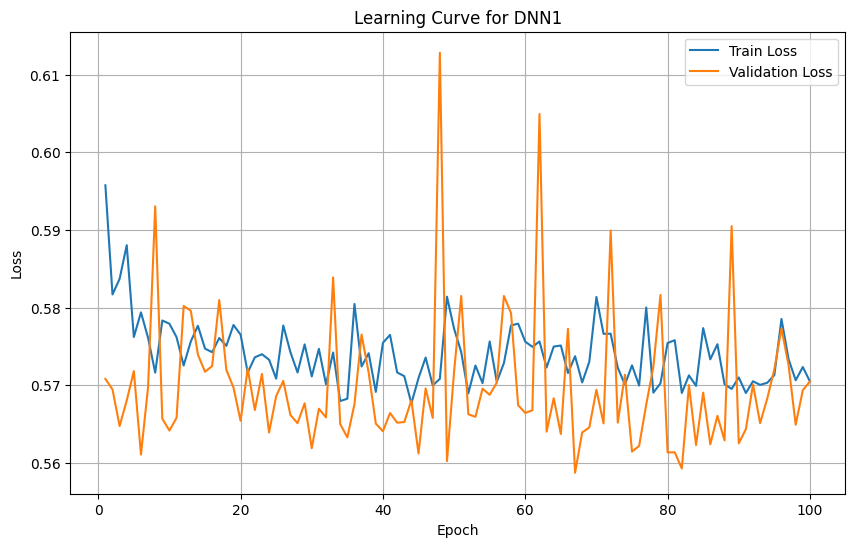

In [13]:
best_params=study.best_params
model = DNN_8(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.66%
Precision: 0.4809
Recall: 0.8909
F1 Score: 0.6246
Matthews Correlation Coefficient: 0.3086
Specificity: 0.3952


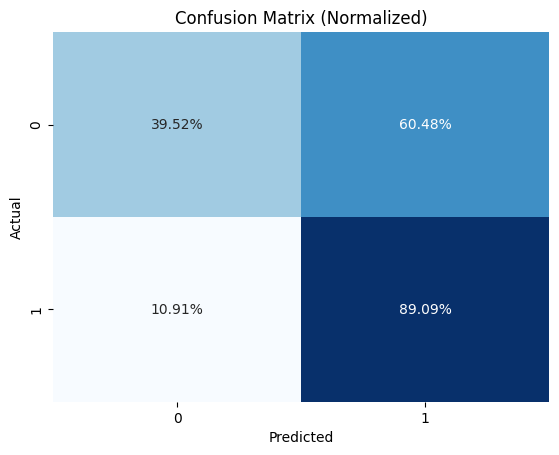

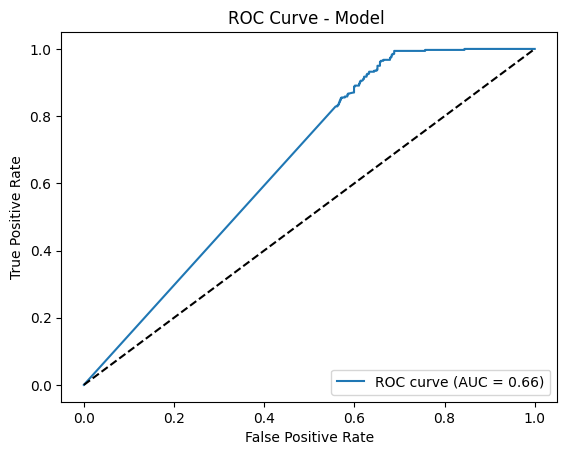

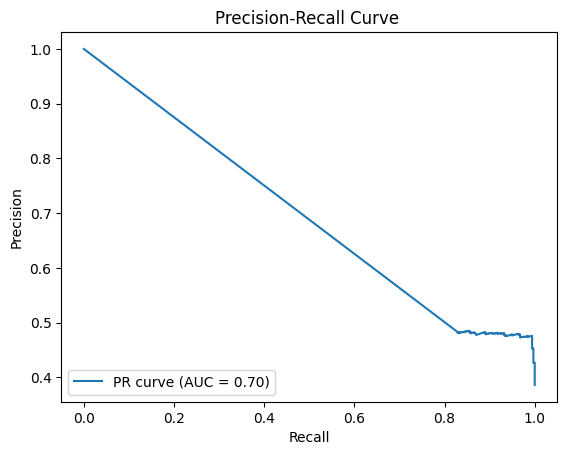

In [23]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.48).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_8.pth')

